In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import json
import os

from tensorflow import keras
import keras_tuner as kt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

## **Utility Functions**

In [2]:
def quick_data_check(df):
    print("DATASET OVERVIEW")
    print("=" * 40)
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())

    return df

def prepare_features_target(df, target_column='Close'):
    """
    Prepare features and target from clean dataset

    Args:
        df: Clean DataFrame
        target_column: Column to predict (default: 'Close')

    Returns:
        feature_columns: List of feature column names
        target_column: Target column name
    """
    print(f"\nPREPARING FEATURES AND TARGET")
    print("=" * 40)

    feature_columns = [col for col in df.columns if col not in ['Date', target_column]]

    print(f"Target: {target_column}")
    print(f"Features ({len(feature_columns)}):")
    for i, col in enumerate(feature_columns, 1):
        print(f"  {i:2d}. {col}")

    dates = df['Date'].copy()

    return feature_columns, target_column, dates

def scale_data(df, feature_columns, target_column):
    """
    Scale features and target using MinMaxScaler

    Args:
        df: DataFrame
        feature_columns: List of feature columns
        target_column: Target column name

    Returns:
        features_scaled: Scaled features array
        target_scaled: Scaled target array
        feature_scaler: Fitted feature scaler
        target_scaler: Fitted target scaler
    """
    print(f"\nSCALING DATA")
    print("=" * 40)

    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    features_scaled = feature_scaler.fit_transform(df[feature_columns])
    print(f"Features scaled: {features_scaled.shape}")

    target_scaled = target_scaler.fit_transform(df[[target_column]])
    print(f"Target scaled: {target_scaled.shape}")

    print(f"\nFeature scaling range: [{features_scaled.min():.3f}, {features_scaled.max():.3f}]")
    print(f"Target scaling range: [{target_scaled.min():.3f}, {target_scaled.max():.3f}]")

    return features_scaled, target_scaled, feature_scaler, target_scaler

def create_sequences(features, target, sequence_length):
    """
    Create sequences for LSTM training

    Args:
        features: Scaled features array
        target: Scaled target array
        sequence_length: Number of time steps to look back

    Returns:
        X: Feature sequences (samples, sequence_length, features)
        y: Target values (samples, 1)
    """
    X, y = [], []

    for i in range(sequence_length, len(features)):
        X.append(features[i-sequence_length:i])
        y.append(target[i])

    return np.array(X), np.array(y)

def create_sequences_with_stride(features, target, sequence_length, stride=2):
    X, y = [], []
    for i in range(sequence_length, len(features), stride):
        X.append(features[i-sequence_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

def split_data(X, y, dates, test_size=0.2, val_size=0.15):
    """
    Split data into train/validation/test sets using sklearn (maintaining temporal order)

    Args:
        X: Feature sequences
        y: Target values
        dates: Corresponding dates
        test_size: Proportion for test set
        val_size: Proportion for validation set

    Returns:
        Dictionary with train/val/test splits
    """
    print(f"\nSPLITTING DATA")
    print("=" * 40)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        shuffle=False,  # Don't shuffle for time series
        random_state=42
    )

    dates_temp = dates[:len(X_temp)]
    dates_test = dates[len(X_temp):]

    val_size_adjusted = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size_adjusted,
        shuffle=False,  # Don't shuffle for time series
        random_state=42
    )

    dates_train = dates_temp[:len(X_train)]
    dates_val = dates_temp[len(X_train):]

    n_samples = len(X)
    print(f"Total samples: {n_samples:,}")
    print(f"Train: {len(X_train):,} ({len(X_train)/n_samples:.1%})")
    print(f"Validation: {len(X_val):,} ({len(X_val)/n_samples:.1%})")
    print(f"Test: {len(X_test):,} ({len(X_test)/n_samples:.1%})")

    print(f"\nDate ranges:")
    print(f"Train: {dates_train[0]} to {dates_train[-1]}")
    print(f"Val: {dates_val[0]} to {dates_val[-1]}")
    print(f"Test: {dates_test[0]} to {dates_test[-1]}")

    return {
        'X_train': X_train, 'y_train': y_train, 'dates_train': dates_train,
        'X_val': X_val, 'y_val': y_val, 'dates_val': dates_val,
        'X_test': X_test, 'y_test': y_test, 'dates_test': dates_test
    }

def visualize_data_split(df, data_result):
    """
    Visualize the train/val/test split
    """
    print(f"\nVISUALIZING DATA SPLIT")
    print("=" * 40)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], alpha=0.3, color='gray', label='Full Data')

    train_dates = data_result['dates_train']
    val_dates = data_result['dates_val']
    test_dates = data_result['dates_test']

    train_mask = df['Date'].isin(train_dates)
    val_mask = df['Date'].isin(val_dates)
    test_mask = df['Date'].isin(test_dates)

    plt.plot(df[train_mask]['Date'], df[train_mask]['Close'],
             color='blue', alpha=0.8, label='Train', linewidth=2)
    plt.plot(df[val_mask]['Date'], df[val_mask]['Close'],
             color='orange', alpha=0.8, label='Validation', linewidth=2)
    plt.plot(df[test_mask]['Date'], df[test_mask]['Close'],
             color='red', alpha=0.8, label='Test', linewidth=2)

    plt.title('Stock Price - Train/Validation/Test Split')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # plt.subplot(2, 1, 2)
    # plt.plot(df['Date'], df['avg_sentiment_score'], alpha=0.7, color='purple')
    # plt.title('Sentiment Score Over Time')
    # plt.xlabel('Date')
    # plt.ylabel('Avg Sentiment Score')
    # plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def save_artifacts(data_result, save_dir="./artifacts/"):
    """
    Save scalers and metadata locally.
    """
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nSAVING ARTIFACTS TO {save_dir}")
    print("=" * 40)

    # Save scalers
    feature_scaler_path = os.path.join(save_dir, "feature_scaler.pkl")
    target_scaler_path = os.path.join(save_dir, "target_scaler.pkl")

    joblib.dump(data_result['feature_scaler'], feature_scaler_path)
    joblib.dump(data_result['target_scaler'], target_scaler_path)

    # Save metadata
    metadata = {
        'feature_columns': data_result['feature_columns'],
        'target_column': data_result['target_column'],
        'input_shape': data_result['input_shape'],
        'sequence_length': data_result['sequence_length'],
        'n_features': data_result['n_features']
    }

    metadata_path = os.path.join(save_dir, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Saved:")
    print(f"  • {feature_scaler_path}")
    print(f"  • {target_scaler_path}")
    print(f"  • {metadata_path}")

    print("\nArtifacts saved locally.")

## **Eval Functions**

In [3]:
def evaluate_predictions(y_true, y_pred, target_scaler, dates=None, plot=True):
    """
    Evaluate model predictions with comprehensive metrics

    Args:
        y_true: True values (scaled)
        y_pred: Predicted values (scaled)
        target_scaler: Scaler to inverse transform
        dates: Corresponding dates (optional)
        plot: Whether to create plots

    Returns:
        Dictionary with evaluation metrics
    """

    print(f"\nMODEL EVALUATION")
    print("=" * 40)

    # Inverse transform predictions to original scale
    y_true_orig = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)

    # Calculate percentage errors
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100

    # Directional accuracy (trend prediction)
    if len(y_true_orig) > 1:
        true_direction = np.diff(y_true_orig) > 0
        pred_direction = np.diff(y_pred_orig) > 0
        directional_accuracy = np.mean(true_direction == pred_direction) * 100
    else:
        directional_accuracy = None

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    if directional_accuracy:
        print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    # Create plots if requested
    if plot:
        create_evaluation_plots(y_true_orig, y_pred_orig, dates)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'directional_accuracy': directional_accuracy,
        'y_true': y_true_orig,
        'y_pred': y_pred_orig
    }

def create_evaluation_plots(y_true, y_pred, dates=None):
    """
    Create comprehensive evaluation plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Actual vs Predicted over time
    axes[0, 0].plot(y_true, label='Actual', alpha=0.8, linewidth=2)
    axes[0, 0].plot(y_pred, label='Predicted', alpha=0.8, linewidth=2)
    axes[0, 0].set_title('Actual vs Predicted Prices')
    axes[0, 0].set_xlabel('Time Steps')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Scatter plot (Actual vs Predicted)
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[0, 1].set_xlabel('Actual Prices')
    axes[0, 1].set_ylabel('Predicted Prices')
    axes[0, 1].set_title('Actual vs Predicted (Scatter)')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Residuals over time
    residuals = y_true - y_pred
    axes[1, 0].plot(residuals, alpha=0.8)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    axes[1, 0].set_title('Residuals Over Time')
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Residuals histogram
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='r', linestyle='--', alpha=0.8)
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model_on_splits(model, data_result, verbose=True):
    """
    Evaluate trained model on all data splits

    Args:
        model: Trained Keras model
        data_result: Dictionary from prepare_lstm_data()
        verbose: Whether to print detailed results

    Returns:
        Dictionary with evaluation results for each split
    """
    print(f"\nEVALUATING MODEL ON ALL SPLITS")
    print("=" * 50)

    results = {}

    # Evaluate on each split
    for split_name in ['train', 'val', 'test']:
        if verbose:
            print(f"\n{split_name.upper()} SET EVALUATION")
            print("-" * 30)

        X = data_result[f'X_{split_name}']
        y_true = data_result[f'y_{split_name}']
        dates = data_result[f'dates_{split_name}']

        # Make predictions
        y_pred = model.predict(X, verbose=0)

        # Evaluate
        eval_results = evaluate_predictions(
            y_true, y_pred,
            data_result['target_scaler'],
            dates,
            plot=verbose
        )

        results[split_name] = eval_results

    # Summary comparison
    if verbose:
        print(f"\nSUMMARY COMPARISON")
        print("=" * 50)
        print(f"{'Metric':<20} {'Train':<12} {'Validation':<12} {'Test':<12}")
        print("-" * 56)

        metrics = ['rmse', 'mae', 'r2', 'mape']
        for metric in metrics:
            train_val = results['train'][metric]
            val_val = results['val'][metric]
            test_val = results['test'][metric]

            if metric == 'r2':
                print(f"{metric.upper():<20} {train_val:<12.4f} {val_val:<12.4f} {test_val:<12.4f}")
            elif metric == 'mape':
                print(f"{metric.upper():<20} {train_val:<12.2f}% {val_val:<12.2f}% {test_val:<12.2f}%")
            else:
                print(f"{metric.upper():<20} {train_val:<12.6f} {val_val:<12.6f} {test_val:<12.6f}")

    return results

def save_model_and_results(model, results, data_result, model_name="lstm_stock_model", save_dir="./model_outputs/"):
    """
    Save trained model and evaluation results to local disk (not Colab).
    """
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nSAVING MODEL AND RESULTS TO {save_dir}")
    print("=" * 40)

    # Save model
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    # Save results
    results_path = os.path.join(save_dir, f"{model_name}_results.json")
    json_results = {}

    for split, metrics in results.items():
        json_results[split] = {}
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                json_results[split][key] = value.tolist()
            elif isinstance(value, (np.float64, np.float32)):
                json_results[split][key] = float(value)
            else:
                json_results[split][key] = value

    with open(results_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    print(f"Results saved to: {results_path}")

    print("\nDone saving model and results locally.")

## **Prepare data for LSTM**

In [4]:
def prepare_lstm_data(df, target_column='Close', sequence_length=60,
                     test_size=0.2, val_size=0.15):
    """
    Complete data preparation pipeline for LSTM

    Args:
        df: Clean DataFrame with columns [Date, Close, High, Low, Open, Volume, avg_sentiment_score, news_count]
        target_column: Column to predict
        sequence_length: LSTM lookback window
        test_size: Test set proportion
        val_size: Validation set proportion

    Returns:
        Dictionary containing all prepared data and scalers
    """
    print("LSTM DATA PREPARATION PIPELINE")
    print("=" * 50)

    # Step 1: Quick data check
    df = quick_data_check(df)

    # Step 2: Prepare features and target
    feature_columns, target_column, dates = prepare_features_target(df, target_column)

    # Step 3: Scale data
    features_scaled, target_scaled, feature_scaler, target_scaler = scale_data(
        df, feature_columns, target_column
    )

    # Step 4: Create sequences
    print(f"\nCREATING SEQUENCES")
    print("=" * 40)
    print(f"Sequence length: {sequence_length}")

    X, y = create_sequences(features_scaled, target_scaled, sequence_length)
    sequence_dates = dates.iloc[sequence_length:].values  # Adjust dates for sequences

    print(f"Sequences created:")
    print(f"  X shape: {X.shape} (samples, sequence_length, features)")
    print(f"  y shape: {y.shape} (samples, 1)")

    # Step 5: Split data
    splits = split_data(X, y, sequence_dates, test_size, val_size)

    # Combine everything
    result = {
        **splits,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'feature_columns': feature_columns,
        'target_column': target_column,
        'input_shape': (sequence_length, len(feature_columns)),
        'sequence_length': sequence_length,
        'n_features': len(feature_columns)
    }

    print(f"\nPREPARATION COMPLETE!")
    print(f"Input shape for LSTM: {result['input_shape']}")

    return result

## **Let's start**

In [5]:
def build_gru_model(hp):
    model = keras.Sequential()

    # First GRU layer
    model.add(keras.layers.GRU(
        units=hp.Int("gru_units_1", min_value=32, max_value=128, step=32),
        return_sequences=hp.Boolean("return_seq_1", default=False),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Optional second GRU layer (only if return_sequences=True above)
    if hp.Boolean("add_second_gru") and hp.get("return_seq_1"):
        model.add(keras.layers.GRU(
            units=hp.Int("gru_units_2", min_value=32, max_value=128, step=32),
            return_sequences=False
        ))

    # Dropout for regularization
    model.add(keras.layers.Dropout(
        rate=hp.Float("dropout", min_value=0.1, max_value=0.4, step=0.1)
    ))

    # Dense hidden layer with L2 regularization
    model.add(keras.layers.Dense(
        units=hp.Int("dense_units", min_value=16, max_value=64, step=16),
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(
            hp.Choice("l2_reg", [1e-4, 1e-3, 1e-2])
        )
    ))

    # Output layer
    model.add(keras.layers.Dense(1))

    # Optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        ),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(), "mae"]
    )

    return model

LSTM DATA PREPARATION PIPELINE
DATASET OVERVIEW
Shape: (1004, 8)
Date range: 2021-07-19 00:00:00 to 2025-07-17 00:00:00
Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'avg_sentiment_score', 'news_count']

First few rows:
        Date       Close        High         Low        Open     Volume  \
0 2021-07-19  139.404251  140.989624  138.640930  140.676459  121434600   
1 2021-07-20  143.025162  143.954862  139.903380  140.392689   96350000   
2 2021-07-21  142.291168  143.005571  141.537642  142.418393   74993500   
3 2021-07-22  143.661285  145.031346  142.692447  142.819672   77338200   
4 2021-07-23  145.383606  145.540189  143.778672  144.395206   71447400   

   avg_sentiment_score  news_count  
0             0.000000         0.0  
1             0.994026         4.0  
2             0.000000         0.0  
3             0.997748         5.0  
4             0.996606         3.0  

PREPARING FEATURES AND TARGET
Target: Close
Features (6):
   1. High
   2. Low
   3. Open
  

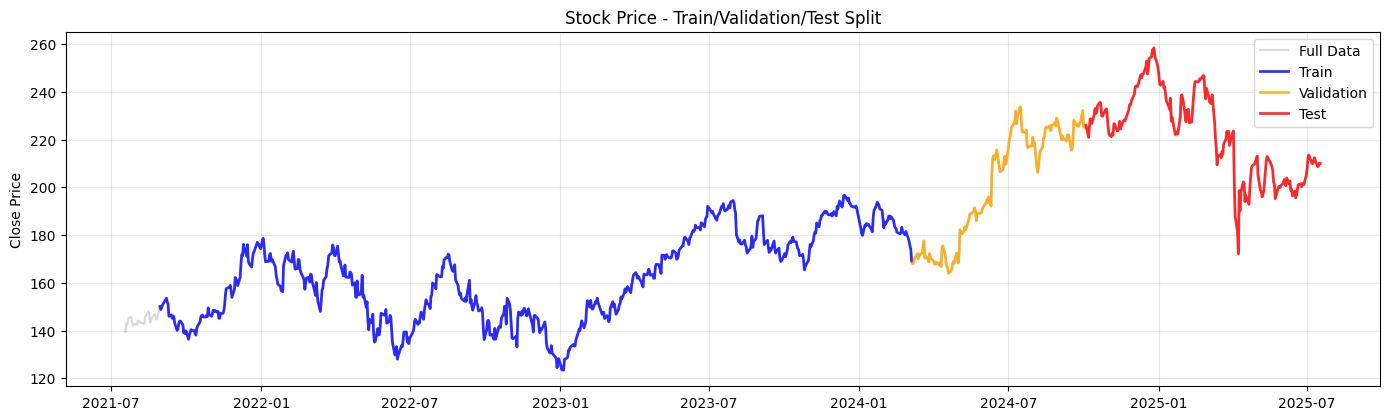


SAVING ARTIFACTS TO ./artifacts/
Saved:
  • ./artifacts/feature_scaler.pkl
  • ./artifacts/target_scaler.pkl
  • ./artifacts/metadata.json

Artifacts saved locally.


In [6]:
df = pd.read_csv('../data/final_merged.csv')
df['Date'] = pd.to_datetime(df['Date'])

data = prepare_lstm_data(
    df=df,
    target_column='Close',
    sequence_length=30,
    test_size=0.2,
    val_size=0.15
)

visualize_data_split(df, data)

save_artifacts(data)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

input_shape = data['input_shape']

In [7]:
tuner = kt.RandomSearch(
    build_gru_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    directory="tuner_dir",
    project_name="stock_gru"
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=kt.HyperParameters().Int("batch_size", 16, 64, step=16),
    callbacks=[stop_early],
    verbose=1
)

# Best hyperparams
best_hps = tuner.get_best_hyperparameters(1)[0]
print(best_hps.values)

# Get the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from tuner_dir\stock_gru\tuner0.json
{'gru_units_1': 128, 'return_seq_1': True, 'add_second_gru': True, 'dropout': 0.2, 'dense_units': 32, 'l2_reg': 0.0001, 'lr': 0.0032782554287141517, 'gru_units_2': 96}


c:\Users\Juls\Desktop\stock-news-predictor\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0737 - mae: 0.1880 - root_mean_squared_error: 0.2534 - val_loss: 0.0091 - val_mae: 0.0521 - val_root_mean_squared_error: 0.0674
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0072 - mae: 0.0406 - root_mean_squared_error: 0.0517 - val_loss: 0.0059 - val_mae: 0.0303 - val_root_mean_squared_error: 0.0391
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0060 - mae: 0.0330 - root_mean_squared_error: 0.0415 - val_loss: 0.0062 - val_mae: 0.0354 - val_root_mean_squared_error: 0.0460
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0055 - mae: 0.0308 - root_mean_squared_error: 0.0387 - val_loss: 0.0052 - val_mae: 0.0280 - val_root_mean_squared_error: 0.0364
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0052 - mae: 0.0293 - root_mean_squared_error: 0.0376 - val_loss: 0.0048 - val_mae: 0.0256 - val_root_mean_squared_error: 0.0336
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/ste


EVALUATING MODEL ON ALL SPLITS

TRAIN SET EVALUATION
------------------------------

MODEL EVALUATION
Mean Squared Error (MSE): 10.625056
Root Mean Squared Error (RMSE): 3.259610
Mean Absolute Error (MAE): 2.550090
R² Score: 0.966552
Mean Absolute Percentage Error (MAPE): 1.62%
Directional Accuracy: 49.60%


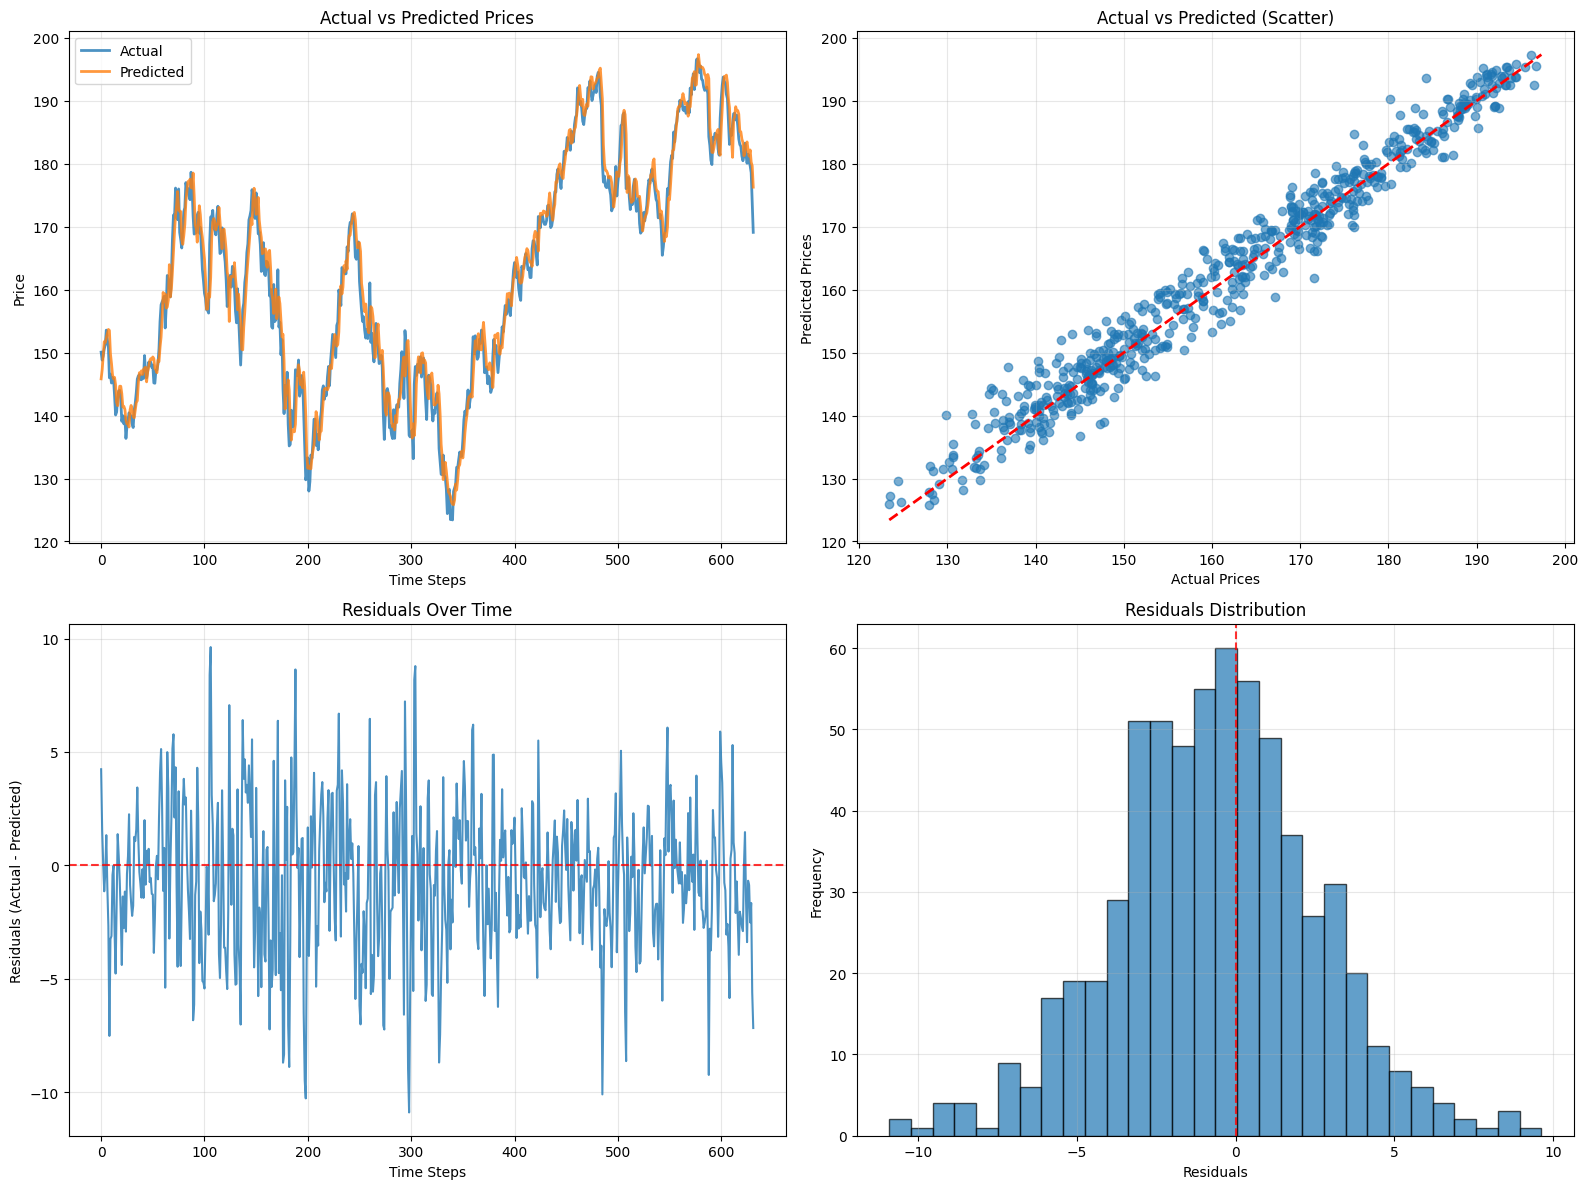


VAL SET EVALUATION
------------------------------

MODEL EVALUATION
Mean Squared Error (MSE): 13.522958
Root Mean Squared Error (RMSE): 3.677357
Mean Absolute Error (MAE): 2.722847
R² Score: 0.974971
Mean Absolute Percentage Error (MAPE): 1.36%
Directional Accuracy: 55.48%


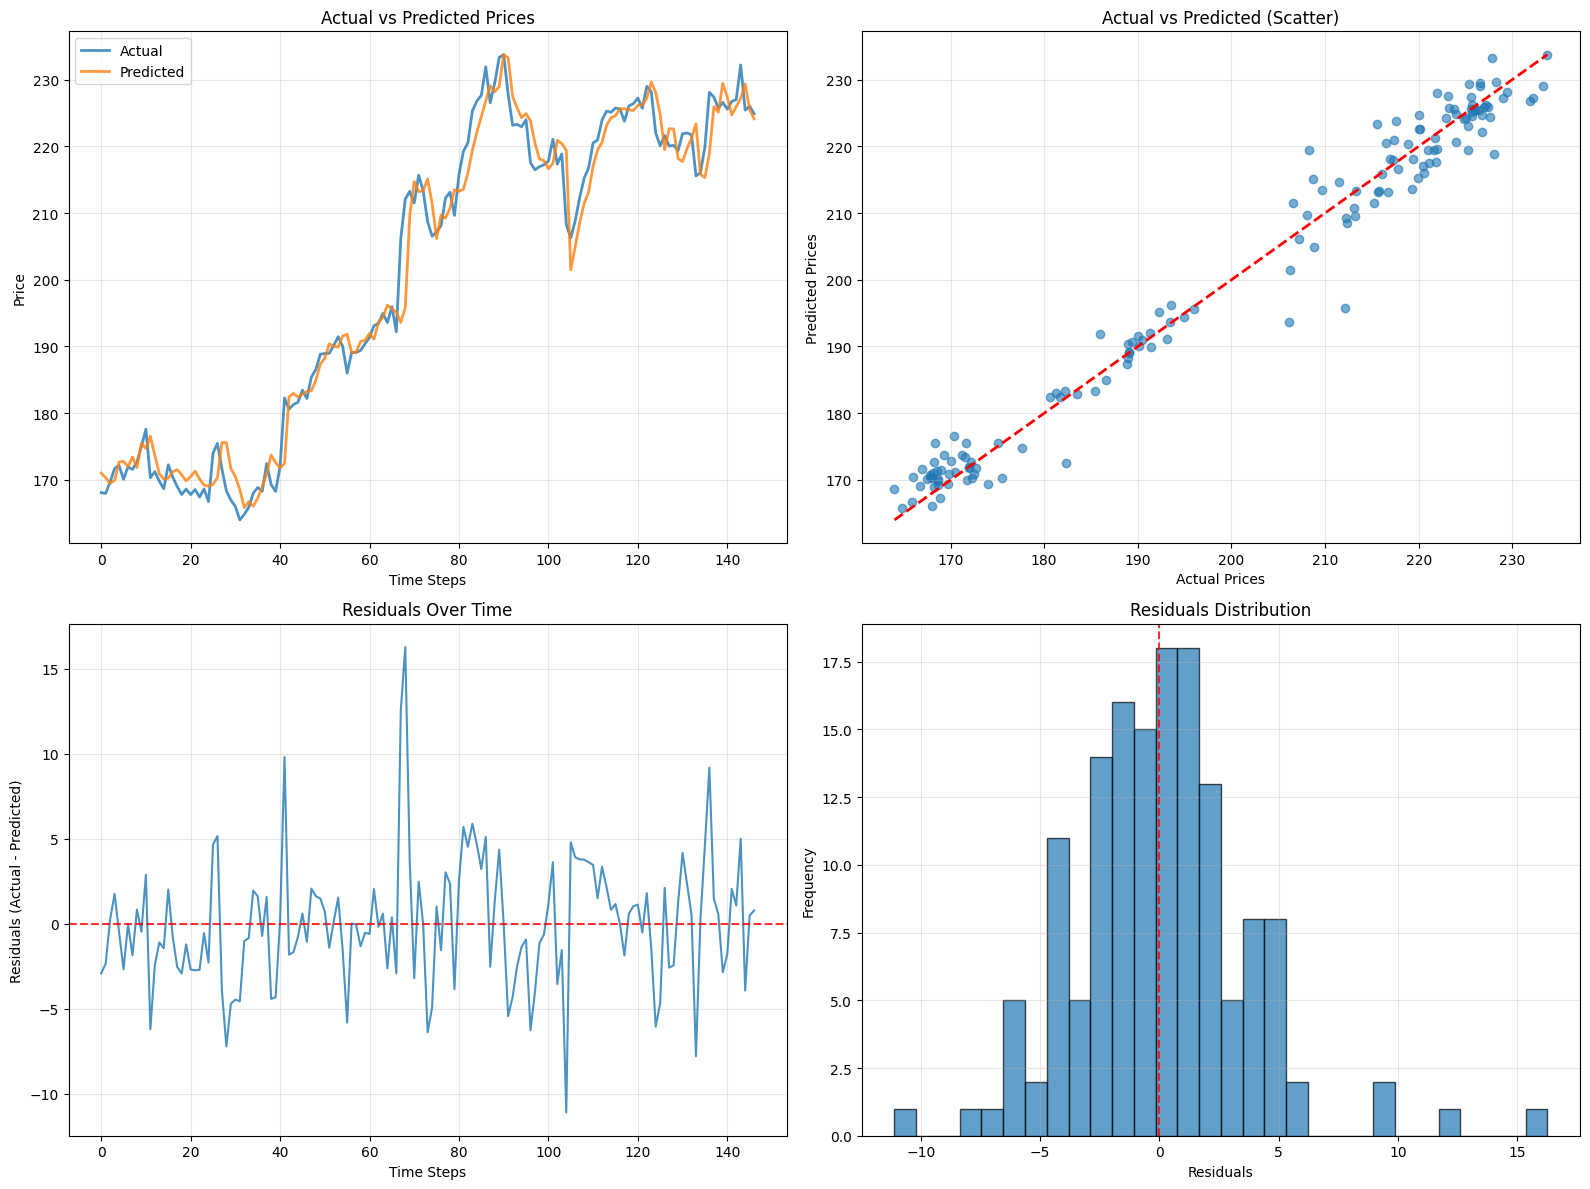


TEST SET EVALUATION
------------------------------

MODEL EVALUATION
Mean Squared Error (MSE): 21.461581
Root Mean Squared Error (RMSE): 4.632665
Mean Absolute Error (MAE): 3.415502
R² Score: 0.930674
Mean Absolute Percentage Error (MAPE): 1.57%
Directional Accuracy: 53.61%


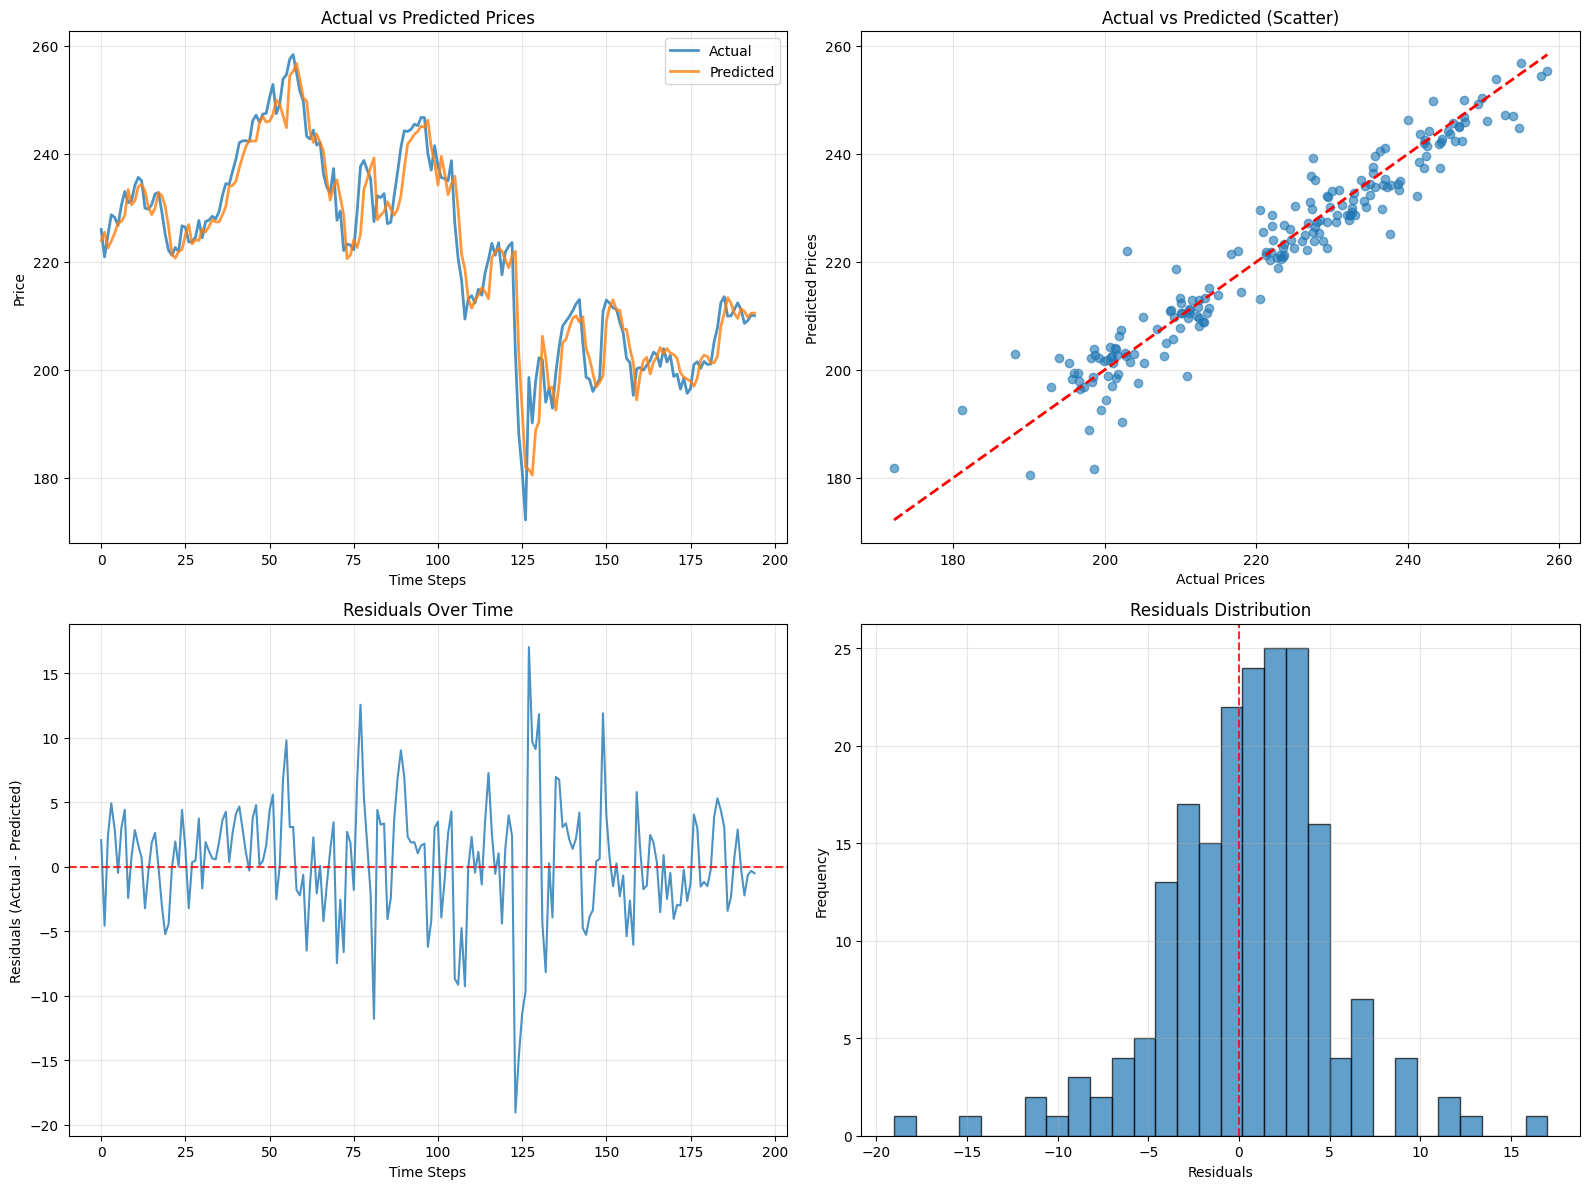


SUMMARY COMPARISON
Metric               Train        Validation   Test        
--------------------------------------------------------
RMSE                 3.259610     3.677357     4.632665    
MAE                  2.550090     2.722847     3.415502    
R2                   0.9666       0.9750       0.9307      
MAPE                 1.62        % 1.36        % 1.57        %


In [9]:
results = evaluate_model_on_splits(best_model, data, verbose=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


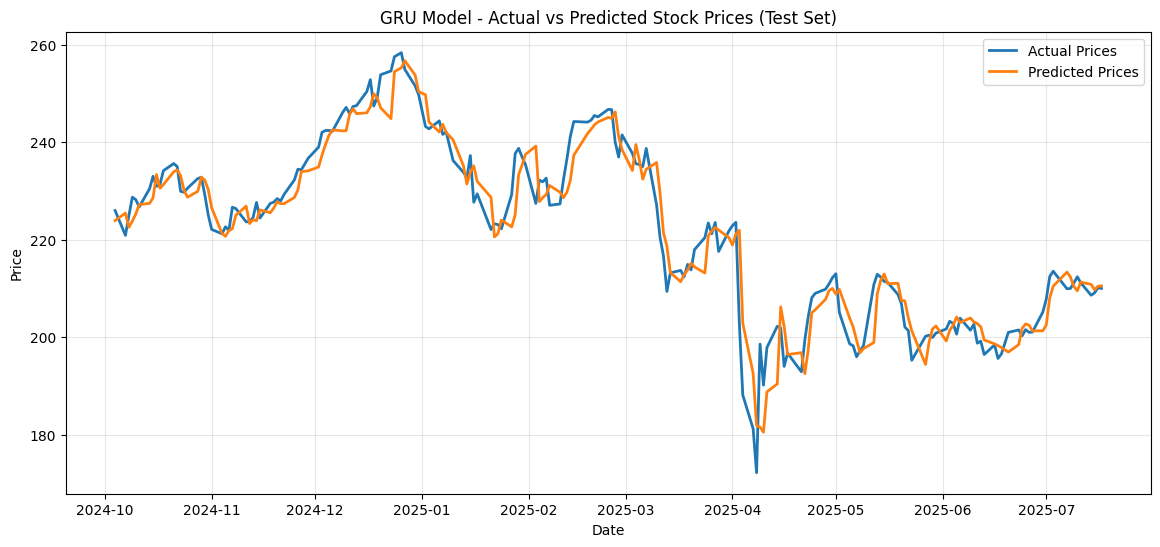

In [10]:
y_pred_test = best_model.predict(X_test)

y_test_orig = data['target_scaler'].inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_test_orig = data['target_scaler'].inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

test_dates = data['dates_test']

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_orig, label="Actual Prices", linewidth=2)
plt.plot(test_dates, y_pred_test_orig, label="Predicted Prices", linewidth=2)
plt.title("GRU Model - Actual vs Predicted Stock Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
save_model_and_results(
    model=best_model,
    results=results,
    data_result=data,
    model_name="gru_stock_model",
    save_dir="./gru_output/"
)


SAVING MODEL AND RESULTS TO ./gru_output/
Model saved to: ./gru_output/gru_stock_model.keras
Results saved to: ./gru_output/gru_stock_model_results.json

Done saving model and results locally.
